# Generating Names with a Character-Level RNN

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [2]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS Marker

def find_files(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_lines(filename):
    with open(filename, encoding='utf-8') as file:
        lines = file.read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]



In [4]:
# Build the category_lines dictionary, a list of lines per category.
category_lines = {}
all_categories = []

for filename in find_files('../../data/names-dataset/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
    


In [6]:
print('# categories:', n_categories, all_categories)
print(unicode_to_ascii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


## Create the Network

In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    


## Training

In [16]:
import random

# Random item from a list
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category.
def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line
    

In [11]:

# One-hot vector for category.
def category_tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
        
    return tensor

# LongTensor of second letter to end (EOS) for target.
def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

    

In [18]:
# Make category, input, and target tensors from a random category, line pair.
def random_training_example():
    category, line = random_training_pair()
    c_tensor = category_tensor(category)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return c_tensor, input_line_tensor, target_line_tensor


In [13]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item() / input_line_tensor.size(0)


In [14]:
import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [19]:
rnn = RNN(n_letters, 128, n_letters)
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))
        
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0



0m 21s (5000 5%) 2.8893
0m 43s (10000 10%) 3.1994
1m 4s (15000 15%) 3.1461
1m 25s (20000 20%) 3.0007
1m 48s (25000 25%) 2.3511
2m 10s (30000 30%) 3.0670
2m 32s (35000 35%) 1.8862
2m 55s (40000 40%) 2.4211
3m 19s (45000 45%) 2.2613
3m 42s (50000 50%) 2.2741
4m 7s (55000 55%) 1.9175
4m 36s (60000 60%) 2.8297
5m 0s (65000 65%) 3.0078
5m 30s (70000 70%) 1.6877
5m 58s (75000 75%) 2.1059
6m 42s (80000 80%) 1.7381
7m 2s (85000 85%) 2.0603
7m 22s (90000 90%) 2.3567
7m 42s (95000 95%) 2.5478
8m 2s (100000 100%) 1.5561


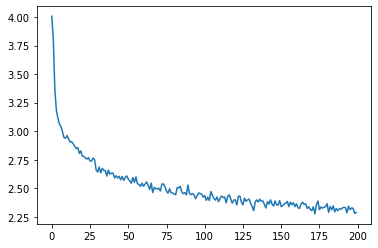

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


## Sampling the Network

In [25]:
max_len = 20

# Sample from a category and starting letter.
def sample(category, start_letter='A'):
    with torch.no_grad(): # no need to track history in sampling.
        cat_tensor = category_tensor(category)
        input = input_tensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_len):
            output, hidden = rnn(cat_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
                
            input = input_tensor(letter)
            
        return output_name
    
# Get multiple samples from one category and multiple starting letters.
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
    

In [27]:
print('> RUSSIAN')
samples('Russian', 'RUS')
print()

print('> GERMAN')
samples('German', 'GER')
print()

print('> SPANISH')
samples('Spanish', 'SPA')
print()

print('> CHINESE')
samples('Chinese', 'CHI')
print()


> RUSSIAN
Rovank
Uantonok
Sakovak

> GERMAN
Gangert
Eran
Ronger

> SPANISH
Sara
Parez
Allan

> CHINESE
Chan
Han
Iua

